# Titanic: Top 5% on Leaderboard

**By: Brian Rafferty**

Welcome to my "Titanic: Machine Learning from Disaster" Jupyter Notebook! This notebook will highlight how I tackled the problem, and can act as a general blueprint to undertake most Data Science projects.

In [1]:
#data analysis and wrangling
import pandas as pd
import numpy as np

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#machine learning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
#access data and create pandas dataframes
train_df = pd.read_csv('../input/titanic/train.csv')
test_df = pd.read_csv('../input/titanic/test.csv')
combine = [train_df, test_df]

In [3]:
#see all of the types of data contained (print every column)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(train_df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [4]:
#print to determine datatypes and see which have nulls
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
#print to determine datatypes and see which have nulls
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# Before moving forward, look at the data and answer these questions:

**Which features are categorical?**
     - Survived, Sex, and Embarked
     - Pclass is ordinal
**Which features are numerical?**
     - Age and Fare are continuous
     - SibSp and Parch are discrete
**Which features are mixed data types?**
     - Ticket and Cabin
**Do any features possibly contain errors? If so, which ones?**
     - Yes, Name has ambiguous data listed
**Which features are missing values?**
     - Cabin, Age, and Embarked

In [6]:
#see distribution statistics for numerical values
train_df[['Age','Fare','SibSp','Parch']].describe()

,Age,Fare,SibSp,Parch
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.523008,0.381594
std,14.526497,49.693429,1.102743,0.806057
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,0.000000
50%,28.000000,14.454200,0.000000,0.000000
75%,38.000000,31.000000,1.000000,0.000000
max,80.000000,512.329200,8.000000,6.000000


In [7]:
#see distribution statistics for categorical values
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Boulos, Mrs. Joseph (Sultana)",male,1601,G6,S
freq,1,577,7,4,644


In [8]:
#analyze the features by pairing them together 'pivoting features'
#Note: only do this with categorical, ordinal, or discrete variables

#strong correlation between being Pclass: 3 and not surviving
print(train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False))


   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [9]:
#strong correlation between being Sex: female and Survived
print(train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False))


      Sex  Survived
0  female  0.742038
1    male  0.188908


In [10]:
#SibSp 5 & 8 have zero correlation with Survived, while other groups do, indicating a
#beneficial opportunity to utilize 'feature engineering' (deriving a new feature or set 
#of features from this one)
print(train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False))


   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


In [11]:
#same scenario with the feature Parch, will also conduct feature engineering here
print(train_df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False))


   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


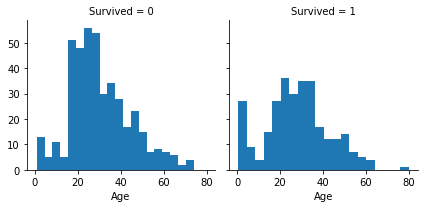

In [12]:
#analyze the numerical features now (charts are useful for these)
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

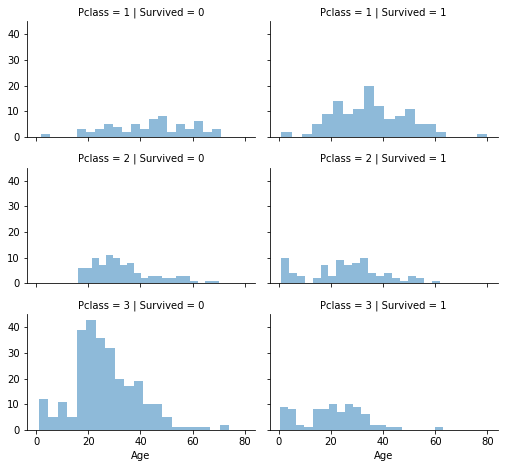

In [13]:
#can plot comparisons between continuous and categorical if the categorical is numeric
g = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
g.map(plt.hist, 'Age', alpha=0.5, bins=20)
g.add_legend()

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:733: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


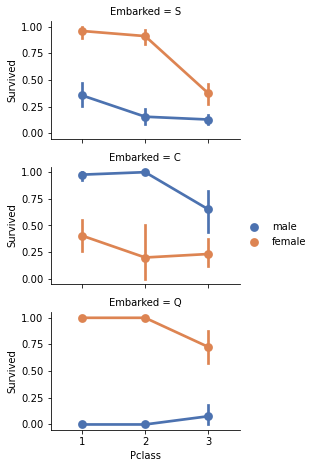

In [14]:
#plot the categorical features that indicated highest correlation, compare based upon where they embarked
g = sns.FacetGrid(train_df, row='Embarked', height=2.2, aspect=1.6)
g.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
g.add_legend()

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


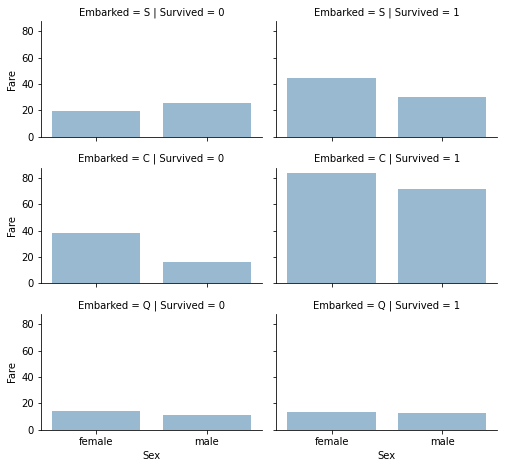

In [15]:
#plot the categorical features that indicated highest correlation, compare 
#based upon where they embarked and their fare price
g = sns.FacetGrid(train_df, row='Embarked', col='Survived', height=2.2, aspect=1.6)
g.map(sns.barplot, 'Sex', 'Fare', alpha=0.5, ci=None)
g.add_legend()

In [16]:
#Wrangle the data

#Correcting
#start with correcting the data by dropping features that have no use
print('Before', train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print('After', train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before (891, 12) (418, 11) (891, 12) (418, 11)
After (891, 10) (418, 9) (891, 10) (418, 9)


In [17]:
#Creating
#create new feature by extracting from existing
#pull title out of name feature
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

print(pd.crosstab(train_df['Title'], train_df['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [18]:
#wrangle the new Title feature, compress every row with low counts into 1 row
#then compress variations into same row (Mlle == Miss, Ms == Miss, Mme == Mrs)
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [19]:
#compare the engineered feature Title with Survived to see correlation
print(train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


In [20]:
#convert the categorical titles to ordinal for future use in the ML model
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

print(train_df[['Name', 'Title']].head())

                                                Name  Title
0                            Braund, Mr. Owen Harris      1
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      3
2                             Heikkinen, Miss. Laina      2
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      3
4                           Allen, Mr. William Henry      1


In [21]:
#now drop Name and PassengerId feature, since they are no 
#longer needed in the training set
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

In [22]:
#convert the categorical feature Sex to numerical values 
#for future use in the ML model
sex_mapping = {'male': 0, 'female': 1}

for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

print(train_df[['Title', 'Sex']].head())

   Title  Sex
0      1    0
1      3    1
2      2    1
3      3    1
4      1    0


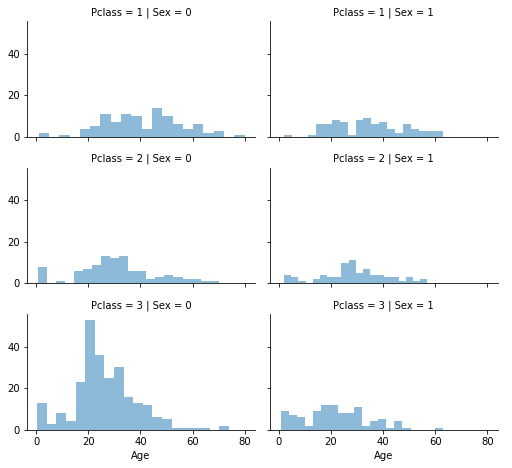

In [23]:
#Completing
#now is time to complete a numerical continuous feature with 
#missing or null values
#start with Age
#guess ages by using the median values across Pclass and gender (Age 
#for Pclass=1 and Gender=0, Pclass=1 and Gender=1, ...)
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=0.5, bins=20)
grid.add_legend()

In [24]:
#start with an empty array to contain the guessed ages
guess_ages = np.zeros((2,3))

#now iterate over Sex (0,1) and Pclass(1,2,3) to calc the guessed ages
for dataset in combine:
    for i in range(2):
        for j in range(3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()
            
            age_guess = guess_df.median()
            
            #convert random age float to nearest .5 age
            guess_ages[i,j] = int(age_guess/0.5 + 0.5) * 0.5
            

    for i in range(2):
        for j in range(3):
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1), 'Age'] = guess_ages[i,j]
            
    dataset['Age'] = dataset['Age'].astype(int)

print(train_df.head())

   Survived  Pclass  Sex  Age  SibSp  Parch     Fare Embarked  Title
0         0       3    0   22      1      0   7.2500        S      1
1         1       1    1   38      1      0  71.2833        C      3
2         1       3    1   26      0      0   7.9250        S      2
3         1       1    1   35      1      0  53.1000        S      3
4         0       3    0   35      0      0   8.0500        S      1


In [25]:
#create Age bands and determine correlations with Survived
train_df['AgeBand'] = pd.cut(train_df['Age'], 7)
print(train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True))


            AgeBand  Survived
0   (-0.08, 11.429]  0.573529
1  (11.429, 22.857]  0.409756
2  (22.857, 34.286]  0.314448
3  (34.286, 45.714]  0.426829
4  (45.714, 57.143]  0.411765
5  (57.143, 68.571]  0.346154
6    (68.571, 80.0]  0.142857


In [26]:
#replace Age with ordinal values based upon these bands
for dataset in combine:
    dataset.loc[dataset['Age'] <= 11.429, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11.429) & (dataset['Age'] <= 22.857), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 22.857) & (dataset['Age'] <= 34.286), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 34.286) & (dataset['Age'] <= 45.714), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 45.714) & (dataset['Age'] <= 57.143), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 57.143) & (dataset['Age'] <= 68.571), 'Age'] = 5
    dataset.loc[dataset['Age'] > 68.571, 'Age'] = 6
    dataset['Age'] = dataset['Age'].astype(int)


print(train_df[['Age', 'AgeBand']].head())


   Age           AgeBand
0    1  (11.429, 22.857]
1    3  (34.286, 45.714]
2    2  (22.857, 34.286]
3    3  (34.286, 45.714]
4    3  (34.286, 45.714]


In [27]:
#now drop AgeBand, now that ages are placed in correct bands
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

print(train_df.head())

   Survived  Pclass  Sex  Age  SibSp  Parch     Fare Embarked  Title
0         0       3    0    1      1      0   7.2500        S      1
1         1       1    1    3      1      0  71.2833        C      3
2         1       3    1    2      0      0   7.9250        S      2
3         1       1    1    3      1      0  53.1000        S      3
4         0       3    0    3      0      0   8.0500        S      1


In [28]:
#Creating
#create new feature called FamilySize which combines Parch and 
#SibSp, this will allow us to drop 2 columns and replace it with 1
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

#No correlation between FamilySize 8 & 11 and Survived, must engineer new feature
print(train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False))

   FamilySize  Survived
3           4  0.724138
2           3  0.578431
1           2  0.552795
6           7  0.333333
0           1  0.303538
4           5  0.200000
5           6  0.136364
7           8  0.000000
8          11  0.000000


In [29]:
#Make a new feature called IsAlone to eliminate values of zero
for dataset in combine:
    dataset['IsAlone'] = 0
    #change value to 1 if family size is 1 person
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

#Notice correlation between not being alone and surviving
print(train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


In [30]:
#drop Parch, SibSp, and FamilySize and keep IsAlone
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

print(train_df.head())

   Survived  Pclass  Sex  Age     Fare Embarked  Title  IsAlone
0         0       3    0    1   7.2500        S      1        0
1         1       1    1    3  71.2833        C      3        0
2         1       3    1    2   7.9250        S      2        1
3         1       1    1    3  53.1000        S      3        0
4         0       3    0    3   8.0500        S      1        1


In [31]:
#create artificial feature combining Pclass and Age
for dataset in combine:
   dataset['Age*Class'] = dataset.Age * dataset.Pclass

print(train_df[['Age*Class', 'Survived']].groupby(['Age*Class'], as_index=False).mean())

    Age*Class  Survived
0           0  0.573529
1           1  0.800000
2           2  0.647059
3           3  0.432773
4           4  0.465116
5           5  0.388889
6           6  0.217391
7           8  0.333333
8           9  0.115385
9          10  0.250000
10         12  0.000000
11         15  0.250000
12         18  0.000000


In [32]:
#create artificial feature combining Title and Class
for dataset in combine:
   dataset['Title*Class'] = dataset.Title * dataset.Pclass
    
print(train_df[['Title*Class', 'Survived']].groupby(['Title*Class'], as_index=False).mean())

   Title*Class  Survived
0            1  0.345794
1            2  0.388489
2            3  0.215470
3            4  0.947368
4            5  0.533333
5            6  0.615385
6            8  1.000000
7            9  0.500000
8           10  0.000000
9           12  0.392857


In [33]:
#Completing
#complete the embarked feature by find the mode, and 
#filling that value in all the null spots
freq_port = train_df.Embarked.dropna().mode()[0]

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

#Correlation between Embarked: C and Survived
print(train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False))

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


In [34]:
#map Embarked to numeric values for the ML model
port_mapping = {'S': 0, 'C': 1, 'Q': 2}

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map(port_mapping)

print(train_df.head())

   Survived  Pclass  Sex  Age     Fare  Embarked  Title  IsAlone  Age*Class  \
0         0       3    0    1   7.2500         0      1        0          3   
1         1       1    1    3  71.2833         1      3        0          3   
2         1       3    1    2   7.9250         0      2        1          6   
3         1       1    1    3  53.1000         0      3        0          3   
4         0       3    0    3   8.0500         0      1        1          9   

   Title*Class  
0            3  
1            3  
2            6  
3            3  
4            3  


In [35]:
#Completing
#fill the missing fare values by finding the mode and 
#replacing the nulls with it
freq_fare = train_df.Fare.dropna().mode()[0]

for dataset in combine:
    dataset['Fare'] = dataset['Fare'].fillna(freq_fare)

In [36]:
#create new feature called FareBand, just like AgeBand before
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
print(train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True))

          FareBand  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


In [37]:
#convert Fare into ordinal values based upon results
for dataset in combine:
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31.0), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31.0, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

#remove FareBand feature
train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]

print(train_df.head())

   Survived  Pclass  Sex  Age  Fare  Embarked  Title  IsAlone  Age*Class  \
0         0       3    0    1     0         0      1        0          3   
1         1       1    1    3     3         1      3        0          3   
2         1       3    1    2     1         0      2        1          6   
3         1       1    1    3     3         0      3        0          3   
4         0       3    0    3     1         0      1        1          9   

   Title*Class  
0            3  
1            3  
2            6  
3            3  
4            3  


In [38]:
#check test values too, make sure everything is set 
print(test_df.head())

   PassengerId  Pclass  Sex  Age  Fare  Embarked  Title  IsAlone  Age*Class  \
0          892       3    0    2     0         2      1        1          6   
1          893       3    1    4     0         0      3        0         12   
2          894       2    0    5     1         2      1        1         10   
3          895       3    0    2     1         0      1        1          6   
4          896       3    1    1     1         0      3        0          3   

   Title*Class  
0            3  
1            9  
2            2  
3            3  
4            9  


In [39]:
#Modeling
#time to train a model and predict a solution
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.5, random_state=1)
X_test = test_df.drop('PassengerId', axis=1).copy()

In [40]:
#Model Selection
#this is a linear problem, can we figure out a 
#function f(x) = y that predicts survivability?
#spot check Linear ML algorithms to determine the 
#most accurate one
#notice they are all close, but SVM is highest
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('SVM', SVC(gamma='auto')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('PERC', Perceptron()))
models.append(('LSVC', LinearSVC()))
models.append(('SGD', SGDClassifier()))
models.append(('RF', RandomForestClassifier()))

for name, model in models:
    model.fit(X_train, Y_train)
    score = model.score(X_train, Y_train)
    print('Accuracy of {} on training set: {}'.format(name, score))

    testScore = model.score(X_validation, Y_validation)
    print('Accuracy of {} on testing set: {}'.format(name, testScore))

Accuracy of LR on training set: 0.8224719101123595
Accuracy of LR on testing set: 0.7757847533632287
Accuracy of SVM on training set: 0.8674157303370786
Accuracy of SVM on testing set: 0.7959641255605381
Accuracy of KNN on training set: 0.8561797752808988
Accuracy of KNN on testing set: 0.7668161434977578
Accuracy of NB on training set: 0.7932584269662921
Accuracy of NB on testing set: 0.7713004484304933
Accuracy of CART on training set: 0.8966292134831461
Accuracy of CART on testing set: 0.7713004484304933
Accuracy of PERC on training set: 0.8247191011235955
Accuracy of PERC on testing set: 0.7847533632286996
Accuracy of LSVC on training set: 0.8134831460674158
Accuracy of LSVC on testing set: 0.773542600896861
Accuracy of SGD on training set: 0.7662921348314606
Accuracy of SGD on testing set: 0.7309417040358744


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy of RF on training set: 0.8966292134831461
Accuracy of RF on testing set: 0.7780269058295964


In [41]:
#tune hyperparameters for SVM
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
model = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
model.fit(X_train, Y_train)
hyperparams = model.best_params_
print(hyperparams)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.640, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.652, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.652, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.652, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.652, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.820, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.640, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.640, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.652, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.640, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.640, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.640, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.640, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    1.5s finished


In [42]:
#best params: {'C': 100, 'gamma': 0.01, kernel': 
#'rbf'}
#Original Train: 0.8674157303370786; Tuned Train: 
#0.8674157303370786
#Original Validation: 0.7959641255605381; 
#Tuned Validation: 0.7959641255605381
#normally tuning hyperparameters will yield 
#positive results, but in this case
#it made no difference
tuned_model = SVC(C=100, gamma=0.01, kernel='rbf')
tuned_model.fit(X_train, Y_train)
train_score = tuned_model.score(X_train, Y_train)
test_score = tuned_model.score(X_validation, Y_validation)
print("Train: {}\nValidation: {}".format(train_score, test_score))

Train: 0.8674157303370786
Validation: 0.7959641255605381


In [43]:
#make predictions with model and save output data
predictions = model.predict(X_test)

submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predictions})

print('Printing Submission CSV')

submission.to_csv('./submission.csv', index=False)


Printing Submission CSV


# Final score with test.csv outputs 0.79665

- Teams with this score start appearing at position 785. With 18,058 total teams, that means this analysis and model results in the **top 4.3%** of all submissions! 

- Success aside, there is still much room to improve my skillset with feature engineering, which is the most likely candidate holding the model back from better predictions.